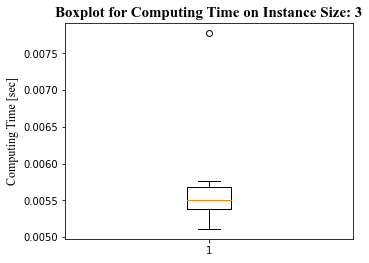

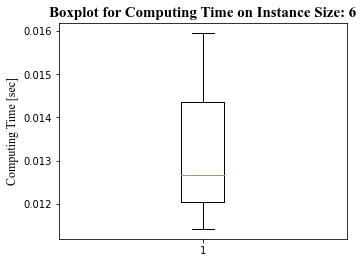

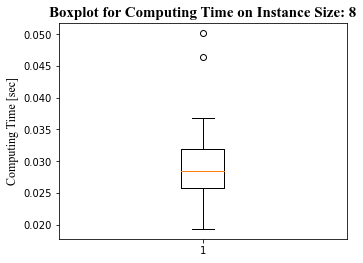

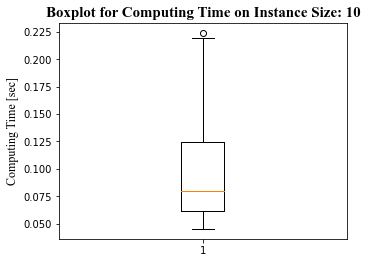

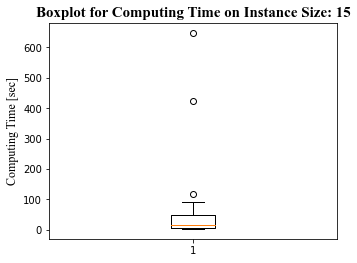

In [32]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
font = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        } 
font_2 = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }
def csv_to_data(path):
        # Creating dataset
        df=pd.read_csv(path).transpose()
        #print(df[0])
        return df[0][1:].values.astype(np.float64)
data_ref = np.random.normal(100, 10, 200)
data_1 = csv_to_data('/Users/felix/sciebo/masterarbeit/progra/model-based_rl/exact_solver/output3.csv')
data_2 = csv_to_data('/Users/felix/sciebo/masterarbeit/progra/model-based_rl/exact_solver/output6.csv')
data_3 = csv_to_data('/Users/felix/sciebo/masterarbeit/progra/model-based_rl/exact_solver/output8.csv')
data_4 = csv_to_data('/Users/felix/sciebo/masterarbeit/progra/model-based_rl/exact_solver/output10.csv')
data_5 = csv_to_data('/Users/felix/sciebo/masterarbeit/progra/model-based_rl/exact_solver/output15.csv')
size=[3,6,8,10,15]

data = [data_1, data_2, data_3, data_4, data_5]

for datum,size_i in zip(data,size): 
        fig = plt.figure(figsize =(4, 3))
        
        # Creating axes instance
        ax = fig.add_axes([0, 0, 1, 1])
        
        # Creating plot
        bp = ax.boxplot(datum)
        #plt.xlabel('Size: '+str(size_i), fontdict=font)
        plt.ylabel('Computing Time [sec]', fontdict=font)

        # show plot
        plt.title(f"Boxplot for Computing Time on Instance Size: {size_i}", fontdict=font_2)

        fig.savefig("out"+str(size_i)+".svg", bbox_inches="tight", pad_inches=0)
        #fig.savefig("test.svg", format="svg")
        plt.show()

/Users/felix/miniconda3/envs/customjssp/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


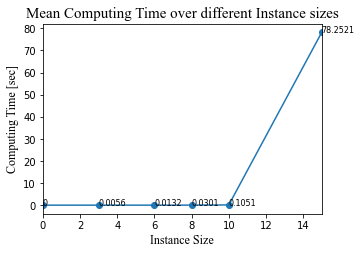

In [40]:
from scipy.optimize import curve_fit
def func(x, a, b, c, d):
    #return a*x**3 + b*x**2 +c*x + d
    return a * np.exp(b * x) 


"""
make the curve_fit
"""

font = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        } 

font_2 = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'normal',
        'size': 15,
        } 
fig, ax = plt.subplots(figsize=(5,3.5))
mean=[]
size_2=[0]+size
mean.append(0)
for datum in data:
    mean.append(round(datum.mean(),4))
plt.scatter(size_2, mean)

z = np.polyfit((size_2), mean, 2)
#p = np.poly1d(z)
#p = scipy.optimize.curve_fit(lambda t,a,b: a+b*np.log(t),  size,  mean)
x = np.array(size_2, dtype=float) #transform your data in a numpy array of floats 
y = np.array(mean, dtype=float) #transform your data in a numpy array of floats 

popt, pcov = curve_fit(func, x, y,maxfev=10000)
plt.xlabel('Instance Size', fontdict=font)
plt.ylabel('Computing Time [sec]', fontdict=font)
for index in range(len(size_2)):
    ax.text(size_2[index], mean[index], mean[index], size=8)  
# giving a title to my graph
plt.title('Mean Computing Time over different Instance sizes', fontdict=font_2)
#plt.plot(size,p(size))
#plt.plot(p)

plt.plot(x, func(x, *popt), label="Fitted Curve") 
plt.xlim([0,15])
fig.savefig("different_instances"+".svg", bbox_inches="tight", pad_inches=0)


In [42]:
print(x)
print(y)
# Import the LinearRegression class
from sklearn.linear_model import LinearRegression

# Create an instance of the LinearRegression class
model = LinearRegression()

# Fit the model to the data
model.fit(x, y)

# Use the model to make predictions for new values of x
x_new = [1, 2, 4, 5, 7, 9, 11, 13]
y_pred = model.predict(x_new)

[ 0.  3.  6.  8. 10. 15.]
[0.00000e+00 5.60000e-03 1.32000e-02 3.01000e-02 1.05100e-01 7.82521e+01]


ModuleNotFoundError: No module named 'sklearn'

In [1]:

if True:
    
    from ray import rllib, tune
    import ray
    from ray.rllib.contrib.alpha_zero.core.alpha_zero_trainer import AlphaZeroTrainer
    from ray.rllib.policy.sample_batch import DEFAULT_POLICY_ID
    from ray.rllib.policy.policy_map import PolicyMap
    from ray.rllib.evaluation.episode import MultiAgentEpisode
    from ray.tune.registry import register_env
    from ray.rllib.contrib.alpha_zero.models.custom_torch_models import DenseModel
    #from src.jss_lite.custom_torch_models import DenseModel_activation_relu as DenseModel
    from ray.rllib.models.catalog import ModelCatalog
    import gym

    import time
    from copy import deepcopy
    import numpy as np
    import os
    import pandas as pd
    import sys
    from pathlib import Path
    from src.jss_lite.jss_lite import jss_lite
    from wrapper.jssplight_wrapper import jssp_light_obs_wrapper
    from wrapper.jssplight_wrapper import jssp_light_obs_wrapper_multi_instances

    def env_creator_variable_instance(config,env_name):
        return jssp_light_obs_wrapper_multi_instances([env_name])
    def reload_ray_validation(instance):
        ray.shutdown()
        ray.init()
        ModelCatalog.register_custom_model("dense_model", DenseModel)    
        tune.register_env('custom_jssp', lambda config:env_creator_variable_instance(config=config,env_name=instance))

    ray.shutdown()

    config_eval = {
        "framework": "torch",
        "disable_env_checking":True,
        "num_workers"       : 7,
        "rollout_fragment_length": 50,
        "train_batch_size"  : 500,
        "sgd_minibatch_size": 64,
        "lr"                : 0.0001,
        "explore"           :False,
        #"horizon"           : 600,
        #"soft_horizon"      : True,
        "num_sgd_iter"      : 1,
        #"horizon"           : 100,
        "mcts_config"       : {
            "puct_coefficient"   : 1.5,
            "num_simulations"    : 100,
            "temperature"        : 1,
            "dirichlet_epsilon"  : 0.20,
            "dirichlet_noise"    : 0.03,
            "argmax_tree_policy" : True,
            "add_dirichlet_noise": False,
        },
        "ranked_rewards"    : {
            "enable": True,
        },
        "model"             : {
            "custom_model": "dense_model",

        },
    }

    def eval_agent_on_instance(_agent,_env):
        policy = _agent.get_policy(DEFAULT_POLICY_ID)
        obs = _env.reset()
        episode = MultiAgentEpisode(
            PolicyMap(0,0),
            lambda _, __: DEFAULT_POLICY_ID,
            lambda: None,
            lambda _: None,
            0,
        )
        episode.user_data['initial_state'] = _env.get_state()
        done = False
        t=time.time()
        while not done:
            action, _, _ = policy.compute_single_action(obs, episode=episode)
            obs, reward, done, _ = _env.step(action)
            episode.length += 1

        return time.time()-t,reward,episode.length

    def get_instance_name(string):
        return string.replace('/', ' ').split(' ')[-1].split('.')[-2]

eval_result={}

checkpoints=['/Users/felix/sciebo/masterarbeit/progra/model-based_rl/training_checkpoints/ima_3_3_no_act_10inner/3x3_0_inst/0/checkpoint-10','/Users/felix/sciebo/masterarbeit/progra/model-based_rl/training_checkpoints/ima_6_6_no_act_10inner/6x6_0_inst/0/checkpoint-10','/Users/felix/sciebo/masterarbeit/progra/model-based_rl/training_checkpoints/ima_8_8_no_act_10inner/8x8_0_inst/0/checkpoint-10','/Users/felix/sciebo/masterarbeit/progra/model-based_rl/training_checkpoints/ima_10_10_no_act_10inner/10x10_0_inst/0/checkpoint-10','/Users/felix/sciebo/masterarbeit/progra/model-based_rl/training_checkpoints/ima_15_15_no_act_10inner/15x15_0_inst/0/checkpoint-10']
instance_list=['/Users/felix/sciebo/masterarbeit/progra/model-based_rl/resources/jsp_instances/ima/3x3x3/3x3_0_inst.json','/Users/felix/sciebo/masterarbeit/progra/model-based_rl/resources/jsp_instances/ima/6x6x6/6x6_0_inst.json','/Users/felix/sciebo/masterarbeit/progra/model-based_rl/resources/jsp_instances/ima/8x8x8/8x8_0_inst.json','/Users/felix/sciebo/masterarbeit/progra/model-based_rl/resources/jsp_instances/ima/10x10x10/10x10_0_inst.json','/Users/felix/sciebo/masterarbeit/progra/model-based_rl/resources/jsp_instances/ima/15x15x15/15x15_0_inst.json']
for eval_path,instance in zip(checkpoints,instance_list):
    reload_ray_validation(instance)
    agent = AlphaZeroTrainer( config=config_eval, env='custom_jssp')
    agent.load_checkpoint(eval_path)
    eval_env=env_creator_variable_instance(config="config",env_name=instance)
    eval_env=env_creator_variable_instance(config="config",env_name=instance)
    eval_tmp={}
    eval_tmp["time"],eval_tmp["reward"],eval_tmp["length"] = eval_agent_on_instance(agent,eval_env)
    eval_tmp["instance"]=get_instance_name(instance)
    eval_tmp['checkpoint']=eval_path
    eval_result[eval_path]=eval_tmp
    results=pd.DataFrame.from_dict(eval_result,orient='index')
    results.to_csv('results'+"only_time"+'.csv')



2022-12-11 18:54:47,207	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-12-11 18:54:47,211	INFO trainer.py:903 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-12-11 18:55:02,717	INFO trainable.py:159 -- Trainable.setup took 15.515 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-12-11 18:55:02,755	WARNING deprecation.py:46 -- DeprecationWarning: `MultiAgentEpisode` has been deprecated. Use `ray.rllib.evaluation.episode.Episode` instead. This will raise an error in the future!
2022-12-11 18:55:09,421	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-12-11 18:55:28,086	INFO trainable.py:159 -- Trainable.setup took 18.666 seconds. If your trainable is slow to initialize, cons

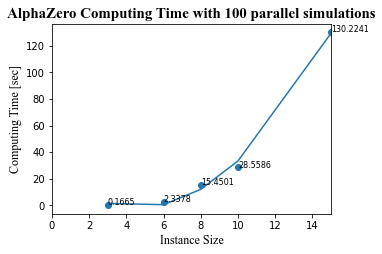

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
def csv_to_data(path):
        # Creating dataset
        df=pd.read_csv(path)
        #print(df[0])
        return df#[0][1:].values()

time_results=csv_to_data('resultsonly_time.csv')


font = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        } 

font_2 = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        } 
fig, ax = plt.subplots(figsize=(5,3.5))
x=[3,6,8,10,15]
y=[round(i,4) for i in time_results['time']]
plt.scatter(x, y)

z = np.polyfit(x, y, 2)
p = np.poly1d(z)
plt.xlabel('Instance Size', fontdict=font)
plt.ylabel('Computing Time [sec]', fontdict=font)
for index in range(len(x)):
    ax.text(x[index], y[index], y[index], size=8)  
# giving a title to my graph
plt.title('AlphaZero Computing Time with 100 parallel simulations', fontdict=font_2)
#plt.plot(size,p(size))
#plt.plot(p)
plt.plot(x,p(x))
plt.xlim([0,15])
fig.savefig("different_instances_AlphaZero"+".svg", bbox_inches="tight", pad_inches=0)

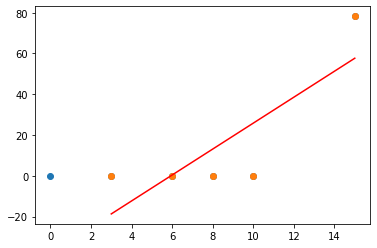

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def csv_to_data(path):
        # Creating dataset
        df=pd.read_csv(path).transpose()
        #print(df[0])
        return df[0][1:].values.astype(np.float64)
data_1 = csv_to_data('/Users/felix/sciebo/masterarbeit/progra/model-based_rl/exact_solver/output3.csv')
data_2 = csv_to_data('/Users/felix/sciebo/masterarbeit/progra/model-based_rl/exact_solver/output6.csv')
data_3 = csv_to_data('/Users/felix/sciebo/masterarbeit/progra/model-based_rl/exact_solver/output8.csv')
data_4 = csv_to_data('/Users/felix/sciebo/masterarbeit/progra/model-based_rl/exact_solver/output10.csv')
data_5 = csv_to_data('/Users/felix/sciebo/masterarbeit/progra/model-based_rl/exact_solver/output15.csv')
size=[3,6,8,10,15]

data = [data_1, data_2, data_3, data_4, data_5]

mean=[]
size_2=[0]+size
mean.append(0)
for datum in data:
    mean.append(round(datum.mean(),4))
plt.scatter(size_2, mean)

z = np.polyfit((size_2), mean, 2)
#p = np.poly1d(z)
#p = scipy.optimize.curve_fit(lambda t,a,b: a+b*np.log(t),  size,  mean)
x = np.array(size_2[1:], dtype=float) #transform your data in a numpy array of floats 
y = np.array(mean[1:], dtype=float) #transform your data in a numpy array of floats 

plt.scatter(x, y)
coefficients = np.polyfit(x, y, 1)
poly = np.poly1d(coefficients)
plt.plot(x, poly(x), 'r')
plt.show()


y = exp(-12.689421751826194) * exp(5.264136545886779 * x)


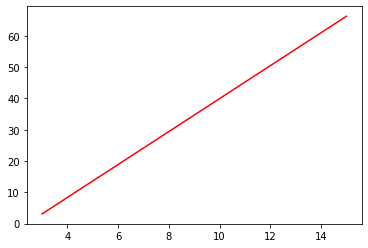

In [29]:
x_transformed = np.log(x)
y_transformed = np.log(y)

# Fit an exponential curve to the transformed data
coefficients = np.polyfit(x_transformed, y_transformed, 1)

# Print the equation of the curve
print(f'y = exp({coefficients[1]}) * exp({coefficients[0]} * x)')
poly = np.poly1d(coefficients)
plt.plot(x, poly(x), 'r')
plt.show()

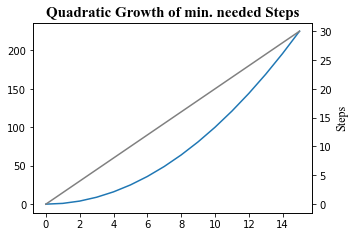

In [70]:
import numpy as np
from scipy.optimize import curve_fit
fig, ax = plt.subplots(figsize=(5,3.5))

# Define the arrays of data points
x = [i for i in range(16)]
#y = mean[1:]

def y_fun(x):
  return x*x

def y_fun_2(x):
  return 2*x

y = [y_fun(i) for i in x ]

y_2 = [y_fun_2(i) for i in x ]

# Define the function that describes the general form of the trendline
#def polynomial_trendline(x, a, b, c, d):
#  return a * x**3 + b * x**2 + c * x + d

# Fit the trendline to the data
#parameters, _ = curve_fit(polynomial_trendline, x, y)
#a, b, c, d = parameters

# Print the equation of the trendline
#print(f'y = {a:.4f} * x**3 + {b:.4f} * x**2 + {c:.4f} * x + {d:.4f}')
#y_2=[polynomial_trendline(x,a,b,c,d) for x in x ]
ax.plot(x,y)
ax2=ax.twinx()
ax2.plot(x,y_2,color='gray')
ax.xlabel('Instance Size', fontdict=font)
ax.ylabel('Steps', fontdict=font)
ax.ylabel('Action Space', fontdict=font)

# giving a title to my graph
plt.title('Quadratic Growth of min. needed Steps', fontdict=font_2)
plt.show()
fig.savefig("quadratic_growth_min_steps"+".svg", bbox_inches="tight", pad_inches=0)

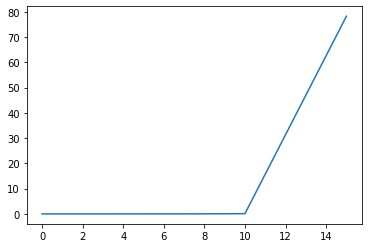

In [46]:
x=[ 0.,  3.,  6.,  8., 10., 15.]
y=[0.00000e+00, 5.60000e-03, 1.32000e-02, 3.01000e-02, 1.05100e-01, 7.82521e+01]
plt.plot(x,y)

plt.show()

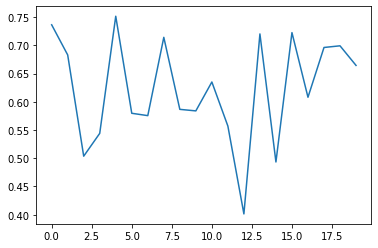

In [53]:
import json
with open("every_action.json", 'r') as f:
    every_action = json.load(f)

with open("every_action_time.json", 'r') as f:
    every_action_time = json.load(f)

with open("train_rewards.json", 'r') as f:
    train_rewards = json.load(f)

plt.plot(train_rewards)

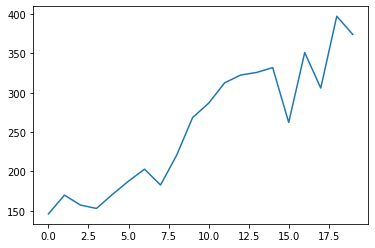

In [56]:
#cum_time=[]

cum_time=[sum(lst)for lst in every_action_time]
plt.plot(cum_time)

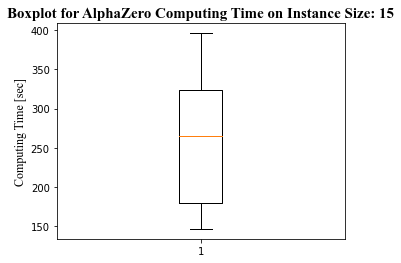

In [60]:
fig = plt.figure(figsize =(4, 3))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(cum_time)
#plt.xlabel('Size: '+str(size_i), fontdict=font)
plt.ylabel('Computing Time [sec]', fontdict=font)

# show plot
plt.title(f"Boxplot for AlphaZero Computing Time on Instance Size: {15}", fontdict=font_2)

fig.savefig("outAZ"+str(15)+".svg", bbox_inches="tight", pad_inches=0)
#fig.savefig("test.svg", format="svg")
plt.show()

225


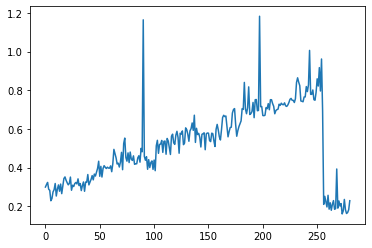

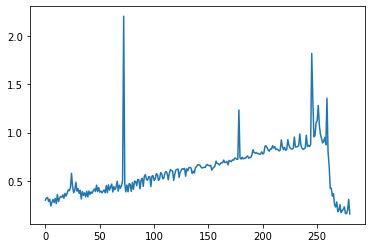

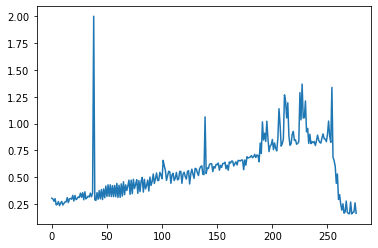

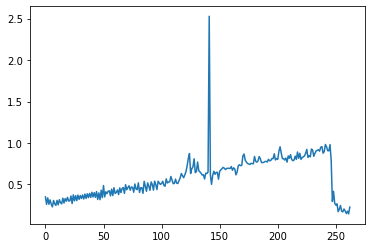

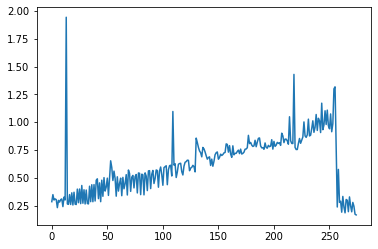

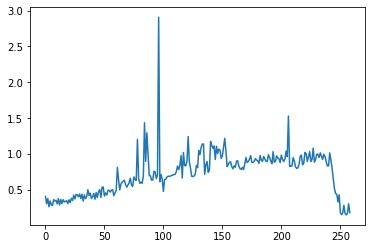

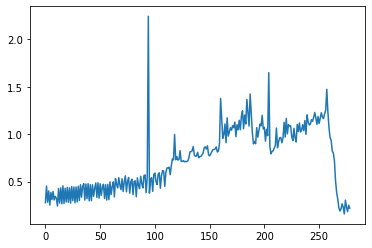

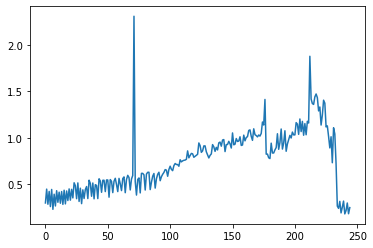

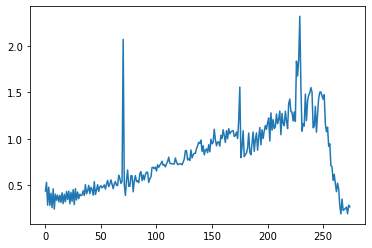

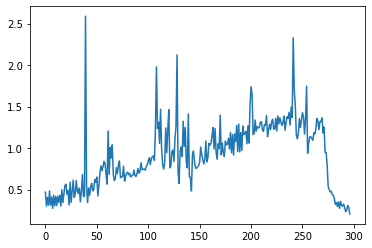

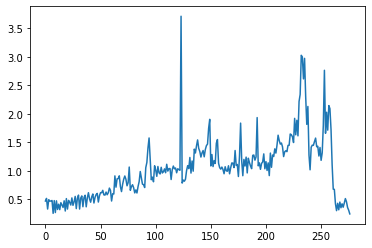

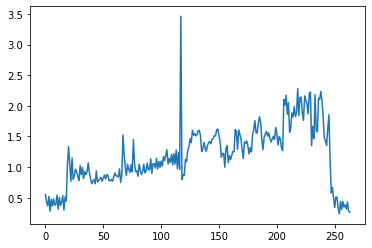

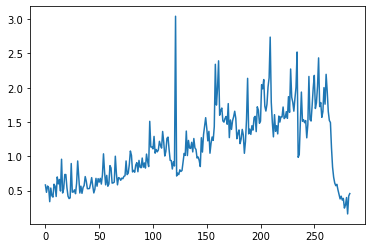

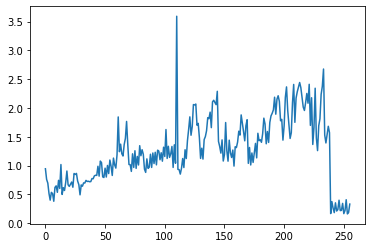

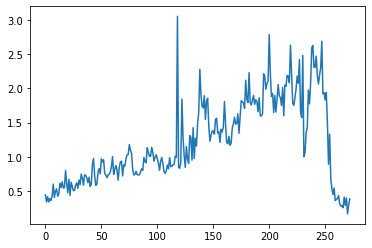

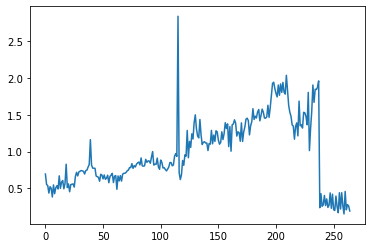

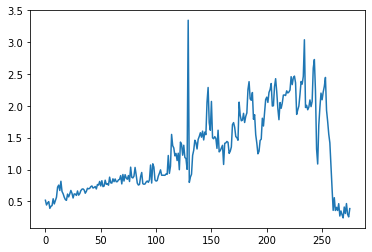

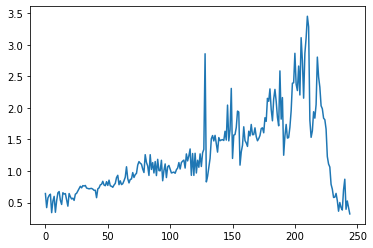

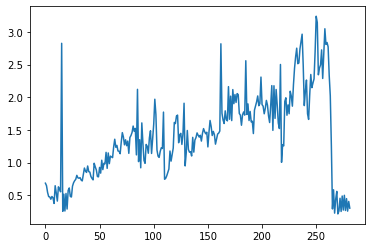

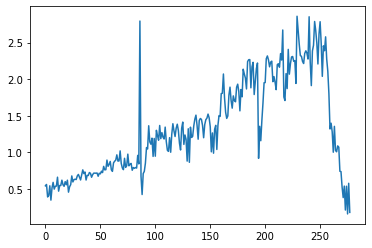

In [59]:
print(15*15)
for lst in every_action_time:
    plt.plot(lst)
    plt.show()